# Module 13 - Programming Assignment

## k Nearest Neighbors and Model Evaluation

You must complete the 4 following tasks:

1. Implement k-Nearest Neighbor *regression* as described in the Module.
2. Use validation curves as described in Module 9 to determine the best value of k trying values of 1 to 10. (You don't need to use odd values for regression). For this you can simply split the data randomly into a training and a test set with a 67/33 split.
3. Use learning curves as described in Module 9 to determine if your model could use more data.
    For this you can simply split the data randomly into a training and a test set with a 67/33 split. Use the best k from part 2.
4. Use 10-fold cross-validation to establish confidence bounds on your model's performance. Calculate the mean (average) MSE (which sounds funny, I know) and the standard deviation. 

Additionally, because you can't be *wrong* with the k = 1 in the training data, your curves will look a little funky initially.

As before make sure you actually plot curves and that everything is labeled. Each chart from part #2 and #3 has *two* curves. Please review the comments to Module 9 if you're not sure why.

Use the data in concrete_compressive_strength.csv for this assignment obtainable at [UCI ML Repository - Concrete Compressive Strength](https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength).

Because the data is always the model, for knn, you simply need a function `knn` that will take the data, a value for k, and a List of instances and return a List of predictions (in this case, we're doing regression...you don't have to write a version of `knn` that would do either).

As before there's a lot of infrastructure involved and the specific names I leave up to you as long as you clearly indicate your answers to 1-4 above.

-----

In [1]:
import csv
import math
import random
import pprint
import matplotlib.pyplot as plt

pp = pprint.PrettyPrinter(indent=4)

&nbsp;

**x**

x

In [2]:
'''
1. Implement k-Nearest Neighbor regression as described in the Module.
'''
##################### K NEAREST NEIGHBOR #####################
#Skip the first row
def read_csv(file_name):
    with open(file_name, 'rb') as f:
        reader = csv.reader(f)
        next(reader, None)
        table = [[float(x) for x in record] for record in reader]
    
    return table[1:len(table)]

&nbsp;

**x**

x

In [3]:
#Euclidean distance without sqrt
def euclidean_distance(row, instance):
    distance = 0.0
    for i in range(len(row) - 2):       #skip the y
        distance += (row[i] - instance[i]) ** 2.0
        
    return distance

&nbsp;

**x**

x

In [4]:
def priority_queue_insert(priority_queue, value):
    added = False
    for i in range(len(priority_queue)):
        entry = priority_queue[i]
        if value[0] < entry[0]:
            priority_queue.insert(i, value)
            added = True
            break
        if value[0] == entry[0]:
            priority_queue.insert(i + 1, value)
            added = True
            break
                
    if not added:
        priority_queue.append(value)

&nbsp;

**x**

x

In [5]:
def average_ys(k_nearest_neighbors):
    sum = 0.0
    for neighbor in k_nearest_neighbors:
        sum += neighbor[-1]
    
    return sum / len(k_nearest_neighbors)

&nbsp;

**x**

x

In [6]:
def predict_instance(data, k, instance):
    distance_priority_queue = []        #List of tuples with distance, y
    for row in data:
        distance = euclidean_distance(row, instance)
        insert_value = (distance, row[-1])
        priority_queue_insert(distance_priority_queue, insert_value)
        
    '''print 'distance_priority_queue[:10]'
    print distance_priority_queue[:10]
    print
    print 'instance'
    print instance
    print'''
    
    prediction = average_ys(distance_priority_queue[:k])    #pass in the k nearest neighbors
    return prediction

&nbsp;

**x**

x

In [7]:
#return a list of predictions (regression)
def k_nearest_neighbors(data, k, instances):
    predictions = []
    for instance in instances:
        predictions.append(predict_instance(data, k, instance))
        
    return predictions

&nbsp;

**x**

x

In [8]:
'''
2. Use validation curves as described in Module 9 to determine the best value of k trying 
    values of 1 to 10. (You don't need to use odd values for regression). For this you can 
    simply split the data randomly into a training and a test set with a 67/33 split.
'''
##################### VALIDATION CURVES #####################
def create_train_test_sets(data):
    random.shuffle(data)
    split_point = len(data) / 10
    test_set = data[:split_point]
    train_set = data[split_point:]
    
    return train_set, test_set

&nbsp;

**x**

x

In [9]:
def plot_validation_curve(k_values, test_error_values, train_error_values):
    plt.plot(k_values, test_error_values, label='test data')
    plt.plot(k_values, train_error_values, label='train data') 
    plt.legend(loc='upper right')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('K Nearest Neighbors')
    plt.show()

&nbsp;

**x**

x

In [10]:
def generate_validation_curves(data):
    train_set, test_set = create_train_test_sets(data)
    train_error_values = []
    test_error_values = []
    k_values = [k for k in range(1, 11)]
    best_k = k_values[0]
    lowest_error = float('inf')
    
    for k in k_values:
        test_predictions = k_nearest_neighbors(train_set, k, test_set)             
        train_predictions = k_nearest_neighbors(train_set, k, train_set)  
        
        test_actuals = [x[-1] for x in test_set]
        train_actuals = [x[-1] for x in train_set]
        
        test_mse = calculate_mean_squared_error(test_actuals, test_predictions)
        train_mse = calculate_mean_squared_error(train_actuals, train_predictions)
        
        average_error = (test_mse + train_mse) / 2.0
        if average_error < lowest_error:
            lowest_error = average_error
            best_k = k
        
        '''print 'test_actuals'
        print test_actuals
        print 
        print 'test_predictions'
        print test_predictions
        print 'test_mse', test_mse
        print'
        print 'train_actuals'
        print train_actuals
        print
        print 'train_predictions'
        print train_predictions
        print 'train_mse', train_mse
        print'''
        
        test_error_values.append(test_mse)
        train_error_values.append(train_mse)
    
        '''print
        print 'actuals'
        print actuals
        print
        print 'predictions'
        print [round(x,2) for x in predictions]'''
    
    plot_validation_curve(k_values, test_error_values, train_error_values)
    return best_k

&nbsp;

**x**

x

In [11]:
'''
3. Use learning curves as described in Module 9 to determine if your model could use more 
    data. For this you can simply split the data randomly into a training and a test set 
    with a 67/33 split. Use the best k from part 2.
'''

def plot_learning_curves(training_set_sizes, test_error_values, train_error_values):
    plt.plot(training_set_sizes, test_error_values, label='test data')
    plt.plot(training_set_sizes, train_error_values, label='train data') 
    plt.legend(loc='upper right')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('Training Set Size (fraction of whole training set)')
    plt.show()

&nbsp;

**x**

x

In [12]:
def generate_learning_curves(data, k):
    training_set_sizes = [.05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95, 1]
    train_set, test_set = create_train_test_sets(data)
    train_error_values = []
    test_error_values = []
    
    
    for percentage in training_set_sizes:
        train_set_size = int(percentage * len(train_set))
        train_set_partition = train_set[:train_set_size]
        
        #print 'train_set_size', train_set_size
        
        test_predictions = k_nearest_neighbors(train_set_partition, k, test_set)             
        train_predictions = k_nearest_neighbors(train_set_partition, k, train_set_partition)  
        
        test_actuals = [x[-1] for x in test_set]
        train_actuals = [x[-1] for x in train_set_partition]
        
        test_mse = calculate_mean_squared_error(test_actuals, test_predictions)
        train_mse = calculate_mean_squared_error(train_actuals, train_predictions)
        
        '''print 'test_mse', test_mse
        print 'train_mse', train_mse
        print
        print''' 
        
        test_error_values.append(test_mse)
        train_error_values.append(train_mse)
     
    plot_learning_curves(training_set_sizes, test_error_values, train_error_values)   

&nbsp;

**x**

x

In [13]:
'''
4. Use 10-fold cross-validation to establish confidence bounds on your model's 
    performance. Calculate the mean (average) MSE (which sounds funny, I know) and the 
    standard deviation.
'''
def create_folds(data, num_folds):
    #folds = [[] for x in range(num_folds)]
    folds = []
    random.shuffle(data)
    
    fold_index = 0
    for i in range(0, len(data) - 1, num_folds):
        if fold_index < num_folds:

            folds.append(data[i:i + num_folds])
            '''for f in folds:
                for instance in f:
                    print instance
            print
            print'''
            fold_index += 1
        
    return folds

&nbsp;

**x**

x

In [14]:
def calculate_mean_squared_error(actuals, predictions):
    mse = 0.0
    num_observations = len(actuals)
    for i in range(num_observations):
        actual = actuals[i]
        prediction = predictions[i]
        mse += (actual - prediction) ** 2.0
    
    mse = mse / num_observations
    return mse

&nbsp;

**x**

x

In [15]:
def calculate_standard_deviation(mean, values):
    standard_deviation = 0.0
    for value in values:
        standard_deviation += (value - mean) ** 2
    
    standard_deviation /= len(values)
    standard_deviation = math.sqrt(standard_deviation)
    return standard_deviation

&nbsp;

**x**

x

In [16]:
def cross_validation(data, k):
    average_mse = 0.0
    mse_values = []
    num_folds = 10
    folds = create_folds(data, num_folds)
    
    for i in range(len(folds)):
        instances = folds[i]                         #chunk of instances
        train = []                              #bigger chunk of instances
        for fold in folds[:i]:
            for instance in fold:
                train.append(instance)
        for fold in folds[i + 1:]:
            for instance in fold:
                train.append(instance)
        
        predictions = k_nearest_neighbors(train, k, instances)        
        actuals = [x[-1] for x in instances]
        mse = calculate_mean_squared_error(actuals, predictions)
        
        average_mse += mse
        mse_values.append(mse)
    
    average_mse = average_mse / num_folds
    standard_deviation = calculate_standard_deviation(average_mse, mse_values)

    return average_mse, standard_deviation

&nbsp;

**x**

x

In [17]:
data = read_csv('concrete-data.csv')

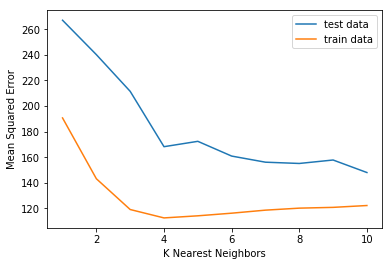

best k 10


In [18]:
best_k = generate_validation_curves(data)
print 'best k', best_k

train_set_size 46
test_mse 202.221170676
train_mse 181.48207613


train_set_size 92
test_mse 223.464759147
train_mse 172.665013315


train_set_size 139
test_mse 208.698886049
train_mse 145.804843799


train_set_size 185
test_mse 213.884305814
train_mse 139.839221276


train_set_size 231
test_mse 201.958684235
train_mse 134.30517529


train_set_size 278
test_mse 188.464976794
train_mse 132.023529072


train_set_size 324
test_mse 184.750964049
train_mse 125.218381182


train_set_size 370
test_mse 182.43838148
train_mse 121.320396886


train_set_size 417
test_mse 185.681012833
train_mse 118.080050122


train_set_size 463
test_mse 189.246950912
train_mse 119.267653689


train_set_size 509
test_mse 177.179285941
train_mse 119.608034389


train_set_size 556
test_mse 164.888220716
train_mse 115.879153297


train_set_size 602
test_mse 167.614268088
train_mse 116.795356982


train_set_size 648
test_mse 165.901210794
train_mse 115.590161147


train_set_size 695
test_mse 157.573078108
train_mse 1

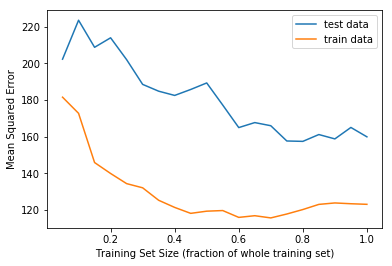

In [19]:
generate_learning_curves(data, best_k)

In [20]:
average_mse, standard_deviation = cross_validation(data, 10)
print "Average MSE: ", average_mse
print "Standard Deviation: ", standard_deviation

[   [   [322.0, 149.0, 0.0, 186.0, 8.0, 951.0, 709.0, 28.0, 52.42],
        [322.0, 0.0, 0.0, 203.0, 0.0, 974.0, 800.0, 14.0, 20.77],
        [279.8, 128.9, 100.4, 172.4, 9.5, 825.1, 804.9, 28.0, 52.83],
        [475.0, 0.0, 0.0, 228.0, 0.0, 932.0, 594.0, 28.0, 39.29],
        [250.0, 0.0, 95.7, 191.8, 5.3, 948.9, 857.2, 3.0, 8.49],
        [397.0, 0.0, 0.0, 185.7, 0.0, 1040.6, 734.3, 28.0, 33.08],
        [313.3, 262.2, 0.0, 175.5, 8.6, 1046.9, 611.8, 91.0, 66.6],
        [149.0, 139.0, 109.0, 193.0, 6.0, 892.0, 780.0, 28.0, 23.69],
        [305.3, 203.5, 0.0, 203.5, 0.0, 965.4, 631.0, 3.0, 14.14],
        [262.0, 111.0, 86.0, 195.0, 5.0, 895.0, 733.0, 28.0, 33.72]],
    [   [160.2, 188.0, 146.4, 203.2, 11.3, 828.7, 709.7, 28.0, 35.31],
        [289.0, 133.7, 0.0, 194.9, 5.5, 924.1, 760.1, 28.0, 46.25],
        [374.0, 189.2, 0.0, 170.1, 10.1, 926.1, 756.7, 91.0, 64.9],
        [228.0, 342.1, 0.0, 185.7, 0.0, 955.8, 674.3, 28.0, 39.7],
        [251.8, 0.0, 99.9, 146.1, 12.4, 1006.0, 8